In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import os

def slope_over_year_1d(group):
    years = group['year'].values
    slopes = {}
    
    for var in group.data_vars:
        y = group[var].values  # shape: (time,)
        
        # Mask NaNs
        mask = ~np.isnan(y) & ~np.isnan(years)
        
        if mask.sum() > 1:
            slope, _, _, _, _ = st.linregress(years[mask], y[mask])
        else:
            slope = np.nan
        
        slopes[var] = slope
    
    # Return a Dataset with slopes for all variables at this dayofyear
    return xr.Dataset(slopes)

# MODELS

In [ ]:
for forcing in ['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55', 'MERRA2.MERRA2', 'ECMWF.ERA5Land']:
    print(forcing)
    
    mc, model = forcing.split('.')

    ## Week of year
    data = xr.open_dataset(os.environ['HOME'] + f'/L2_daily_thresholding/{mc}.{model}.reanalysis.all.daily_SCE.40N_90N.nc')
    reftime = xr.open_dataset(os.environ['HOME'] + f'/L0_Reference/NSIDC_EASE2_N25km_v04.nc').time.dt.day

    data = data.sel(time = data.time.dt.month.isin([9, 10, 11, 12, 1, 2, 3, 4]), drop=True)
    data = data.assign_coords({
                                'weekofyear': data.time.dt.dayofyear//7 + 1,
                                'year': data.time.dt.year
    })
    subset = data.where(data.time.dt.day.isin(reftime), drop=True)

    slopes_ds = subset.groupby('weekofyear').apply(slope_over_year_1d)
    slopes_ds = slopes_ds.where(slopes_ds.weekofyear != 53, drop=True)

    slopes_ds = slopes_ds.assign_coords({'weekofyear':(slopes_ds.weekofyear.values-36)%52+1}).sortby('weekofyear')
    slopes_ds = slopes_ds.sel(weekofyear=slice(0, (14-36)%52+1))

    slopes_ds = slopes_ds.assign_coords({'weekofyear':(slopes_ds.weekofyear*7 + 1)})
    slopes_ds = slopes_ds.rename({'weekofyear':'dayofyear'})
        
    slopes_ds.to_netcdf(os.environ['HOME'] + f'/L2_daily_thresholding/{mc}.{model}.slopes.woy.SeptMarch.nc')


ECMWF.ERA5
NASA.MERRA2
JMA.JRA55
MERRA2.MERRA2
ECMWF.ERA5Land


# NOAA

In [ ]:
NOAA = xr.open_dataset(os.environ['HOME'] + f'/L0_Reference/NSIDC_SCE.weekly.40_90N.nc').NAm.sortby('time') +\
       xr.open_dataset(os.environ['HOME'] + f'/L0_Reference/NSIDC_SCE.weekly.40_90N.nc').Eur.sortby('time')

NOAA = NOAA.sel(time = (NOAA.time.dt.year>1980)&(NOAA.time.dt.year<=2020))
NOAA = NOAA.assign_coords({
    'weekofyear': NOAA.time.dt.dayofyear//7 + 1,
    'year': NOAA.time.dt.year
}).to_dataset(name='SCE')

slopes_ds = NOAA.groupby('weekofyear').apply(slope_over_year_1d)
slopes_ds = slopes_ds.where(slopes_ds.weekofyear != 53, drop=True)

slopes_ds = slopes_ds.assign_coords({'weekofyear':(slopes_ds.weekofyear.values-36)%52+1}).sortby('weekofyear')
slopes_ds = slopes_ds.sel(weekofyear=slice(0, (14-36)%52+1))

slopes_ds = slopes_ds.assign_coords({'weekofyear':(slopes_ds.weekofyear*7 + 1)})
slopes_ds = slopes_ds.rename({'weekofyear':'dayofyear'})
    
slopes_ds.to_netcdf(os.environ['HOME'] + f'/L2_daily_thresholding/NOAA.CDR.slopes.woy.SeptMarch.nc')



# JAXA

In [ ]:
ref = xr.open_dataset(os.environ['HOME'] + f'/L0_Reference/NSIDC_EASE2_N25km_v04.nc')
mask = xr.where((ref.latitude>=40) & (ref.lsmask.isin([1,2])), 1., 0.)

valid_dates_update = xr.open_Dataset(os.environ['HOME'] + f'/L0_JAXA/JAXA.JASMES.sce.final.nc')

snowy = ((valid_dates_update * mask).isin([2, 3])).sum(('x','y')) * 25 * 25 / 1e6 # million km2
snow = ((snowy)).sel(time = snowy.time.dt.month.isin([8, 9, 10, 11, 12, 1, 2, 3, 4]), drop=True)
snow = snow.assign_coords({'dayofyear':snow.time.dt.dayofyear,
                           'weekofyear':snow.time.dt.isocalendar().week,
                            'year': snow.time.dt.year})
snow = snow.where(snow.weekofyear != 53, drop=True)
snow = snow.to_dataset(name='SCE')

slopes_ds = snow.groupby('weekofyear').apply(slope_over_year_1d)
slopes_ds = slopes_ds.assign_coords({'weekofyear':(slopes_ds.weekofyear.values-36)%52+1}).sortby('weekofyear')
slopes_ds = slopes_ds.sel(weekofyear=slice(0, (14-36)%52+1))
slopes_ds = slopes_ds.assign_coords({'weekofyear':(slopes_ds.weekofyear*7)})
slopes_ds = slopes_ds.rename({'weekofyear':'dayofyear'}).drop_duplicates('dayofyear')

slopes_ds.to_netcdf(os.environ['HOME'] + f'/L2_daily_thresholding/JAXA.JASMES.slopes.woy.SeptMarch.nc')



# FIGURE

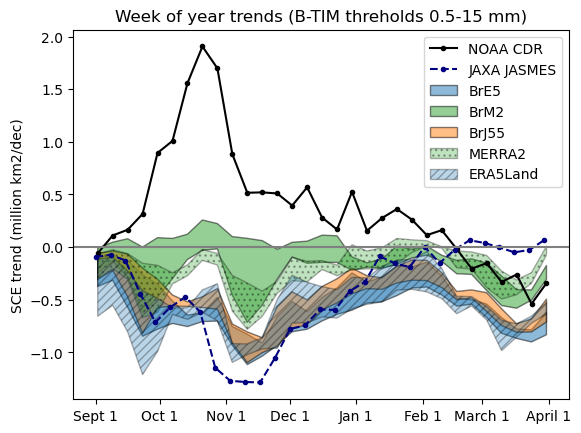

In [ ]:
slopes_ds = xr.open_dataset(os.environ['HOME'] + f'/L2_daily_thresholding/NOAA.CDR.slopes.woy.SeptMarch.nc').drop_duplicates(dim='dayofyear')
plt.plot(slopes_ds.dayofyear, (10*slopes_ds/1e6).SCE, color='black', ls='-', marker='.', label='NOAA CDR')

slopes_ds = xr.open_dataset(os.environ['HOME'] + f'/L2_daily_thresholding/JAXA.JASMES.slopes.woy.SeptMarch.nc').drop_duplicates(dim='dayofyear')
plt.plot(slopes_ds.dayofyear, (10*slopes_ds).SCE, color='navy', ls='--', marker='.', label='JAXA JASMES')

for f,name,color,h,a in zip(['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55', 'MERRA2.MERRA2', 'ECMWF.ERA5Land'], 
                        ['BrE5', 'BrM2', 'BrJ55', 'MERRA2', 'ERA5Land'],
                        ['C0', 'C2', 'C1','C2', 'C0'],
                        ['', '', '', '...', '////'],
                        [0.5,0.5,0.5,0.3,0.3]):
    
    slopes_ds = xr.open_dataset(os.environ['HOME'] + f'/L2_daily_thresholding/{f}.slopes.woy.SeptMarch.nc').drop_duplicates(dim='dayofyear')
    slopes_ds = slopes_ds.drop_vars(['000mm', '155mm', '160mm', '165mm', '170mm', '175mm', '180mm'])
    plt.fill_between(slopes_ds.dayofyear, 10*slopes_ds.to_array(name='SCE').min(dim='variable'), 10*slopes_ds.to_array(name='SCE').max(dim='variable'),
                     label=name, color=color, alpha=a, edgecolor='k', hatch=h)

plt.xticks(7+np.array([0, 30, 61, 91, 122, 153, 181, 212]), ['Sept 1', 'Oct 1', 'Nov 1', 'Dec 1', 'Jan 1', 'Feb 1', 'March 1', 'April 1'])
plt.legend()
plt.title('Week of year trends (B-TIM threholds 0.5-15 mm)')
plt.ylabel('SCE trend (million km2/dec)')
plt.axhline(0, color='grey')

plt.savefig('FigS1.png', dpi=300, bbox_inches='tight')